<a href="https://colab.research.google.com/github/iftakher-m/Compose-image-with-neural-style-transfer/blob/master/8_Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [0]:
vgg= models.vgg19(pretrained=True).features # we only need the features from this image set.

for param in vgg.parameters():
  param.requires_grad= False

In [63]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def load_image(img_path, max_size=400, shape=None): # we are going to take max_size of 400(vert and horz both) for compatibility .
  image= Image.open(img_path).convert('RGB')

  if max(image.size) > max_size: # max will obtain the higest dimension whether vert or horz both
    size= max_size
  else:
    size= max(image.size)

  if shape is not None: # useful when shape is given.
    size= shape


  in_transform= transforms.Compose([
                      transforms.Resize(size), # size--> lower edge(in this can't be over than 400 as set by if , else logic) , this will relatively adjust image shape by setting the lower edge, upper edge will be scaled relatively 
                      transforms.ToTensor(),
                      transforms.Normalize((0.5,), (0.5,))
                     ])
  
  image = in_transform(image).unsqueeze(0)
  return image

In [0]:
content= load_image('emperor-penguins.jpg').to(device)
style= load_image('Universal-Neural-Style-Transfer-with-Color-Mask-Post-Processing.jpg',shape= content.shape[-2:]).to(device) # for optimum result content and style shape should be similar. and we only require the last two values (as they are the dimension)

In [0]:

def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.squeeze() #to remove the additional dimension(this will only require to plot in plt, other wise we need it that's why we set unsqueeze(0) in the above block )
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

(-0.5, 710.5, 399.5, -0.5)

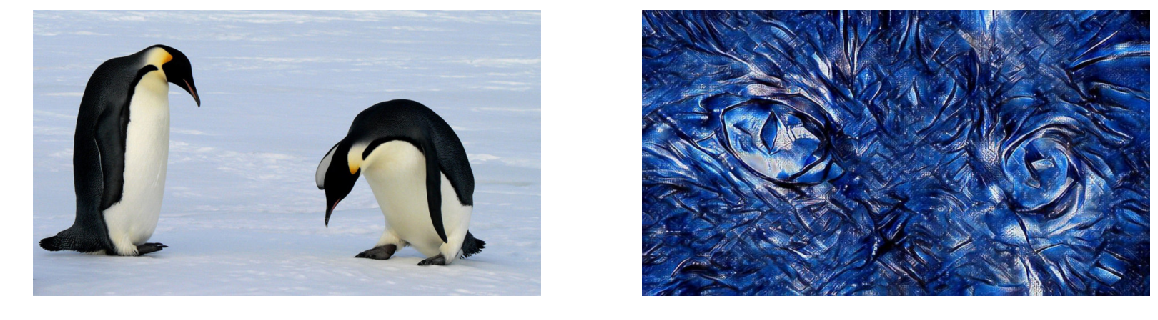

In [67]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10) ) # making a grid arrangement of 1 row and 2 cols for our 2 images

ax1.imshow(im_convert(content))
ax1.axis('off') # to view the image more clearly.

ax2.imshow(im_convert(style))
ax2.axis('off') # to view the image more clearly.


                                      
                                                                          **Feature extraction**

In [0]:
def get_features(image, model): # image--> the pic we want to extract feature from, model--> used to extract those features.
  layers= {'0': 'conv1_1', 
           '5': 'conv2_1', 
           '10': 'conv3_1', 
           '19': 'conv4_1', 
           '21': 'conv4_2', # content extraction
           '28': 'conv5_1', 
           } # keys in the layers dictionary are those convolution layers proved to effective by the research paper (https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf), can be something else for other images (we have exp a little),
             # for extracting features and contents(only conv4_2 for content) and we are assigning names to them accordingly.

  features= {}

  for name, layer in model._modules.items(): # model._modules.items()--> will help to loop thourgh relevent modules in the model (in this case it is layer) and 'name' variable represents as integer inside those models, 'layer' --> information about layers
    image= layer(image) # run our image, the specific layer we are looping through, 'image' variable that we created will store the o/p of the original image in the first layer , this o/p will become i/p for the next layer and this process continues until our image has cycled through the entire model. 

    if name in layers:
      features[layers[name]]= image # the information extracted by the image 'variable' right in the above loop, will be stored in the corresponding value of the key 'name'
  
  return features

In [0]:
content_features= get_features(content, vgg)
style_features= get_features(style, vgg)

                                                                           **Gram matrix**

In [0]:
# we will apply gram matrix to eliminate some 'content' features those will still be present in 'style'
def gram_matrix(tensor):
  _, d, h, w= tensor.size() # unpacking the tensor.size() will give (batch size, depth, height and weight) of the image respectively.
  tensor= tensor.view(d, h*w) # to perform this specific matrix, we have to convert it to a 2d tensor and in doing to we keep the depth(d) i.e. the number of feature channels in our tensor, the same as first parameter and multiply two features (h and w) of each i/p channel to use as the second parameter

  gram= torch.mm(tensor, tensor.t()) # to find the gram matrix we have to multiply (using torch.mm) a matrix and it's transpose.
  return gram


In [0]:
style_grams= {layer: gram_matrix(style_features[layer])  for layer in style_features }

In [0]:
style_weights= {'conv1_1': 1. ,
                'conv2_1': 0.75 ,
                'conv3_1': 0.2 ,
                'conv4_1': 0.2 ,
                'conv5_1': 0.2 ,
                } # it is proven that earlier layers are effective at extracting styles, that's why the layers we created will be now given weight value high(max is 1)--> early stages and low--> final stages
                  # here the 'conv4_2' won't come as it is for content extraction only.

content_weight= 1 # alpha
style_weight= 1e6 # beta (we will find content_weight/style_weight to optimize the presence of style in the target image, the lower the ratio the better, we always have to set content_weight=1 and play around with style_weight= some thing like we 'done here 1e6==> 10^-6)


In [0]:
target= content.clone().requires_grad_(True).to(device) # we want our target image to be the content image first than we will apply style (that's why cloning) and we also want the target image to adjust along with our optimization process (that's why .....(True))

                                                                         **Optimization**

In [0]:
show_every= 300 # we will get an updated image every 300 iteration
optimizer= optim.Adam([target], lr=0.003)
steps= 2100 # the more the accurate, min of 2100 works best in this case.(if there is enough time steps=10k-15k is very common. )

height, width, channels= im_convert(target).shape
image_array= np.empty(shape= (300, height, width, channels)) # we wan't the shape of image_array equal to the shape of our target image. 300 - max array size(max frame to visualize the optimization process), we don't want to store all the images throughout the training process(not memory efficient) , Colab can crash.
capture_frame= steps/300 # we will capture a frame every 7 steps to ensure a total of 300 frames and thus fill the above array.
counter= 0 # to keep track of index array we are at, to make sure the frames get captured in proper order within our array.

Total loss:  5027591.5
Iteration:  300


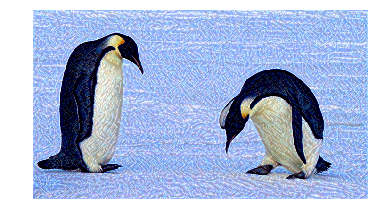

Total loss:  2978587.5
Iteration:  600


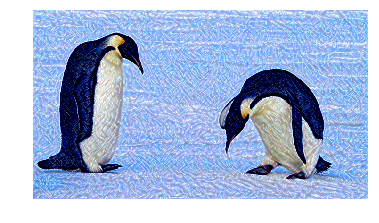

Total loss:  2295937.0
Iteration:  900


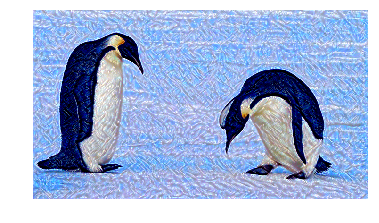

Total loss:  1937538.625
Iteration:  1200


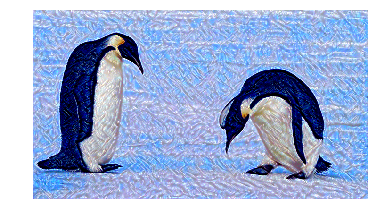

Total loss:  1724057.625
Iteration:  1500


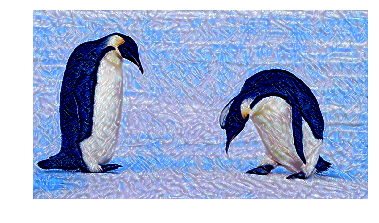

Total loss:  1558616.625
Iteration:  1800


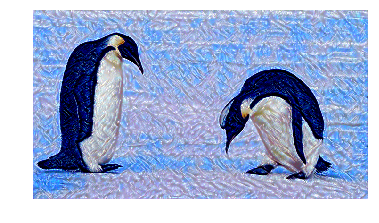

Total loss:  1408381.75
Iteration:  2100


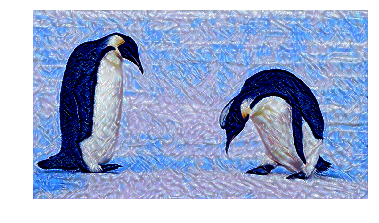

In [75]:
for ii in range(1, steps+1):
  target_features= get_features(target, vgg)
  content_loss= torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2) # we are the finding the MSE error between the content feature of content image and target image , as lower the error higher the chance target image managed to maintain the content features of content image

  style_loss= 0

  for layer in style_weights: # unlike content_loss which deals with only layer, style has 5 layers and we have to loop thorough all of them.
    target_feature= target_features[layer]
    target_gram= gram_matrix(target_feature)
    style_gram= style_grams[layer]
    
    layer_style_loss= style_weights[layer] * torch.mean((target_gram- style_gram)**2) # as not all the 5 layers have same weight values we previously set, we have to multiply the per layer loss respectively to the weight.
    _, d, h, w= target_feature.shape
    style_loss += layer_style_loss / (d * h * w) # we are normalizing at each loop running by dividing by (d * h * w) laye to get to unit loss as we applied the gram matrix to the entire layer.

  total_loss= content_loss*content_weight + style_loss*style_weight # multiplying weight values will calculate loss accordingly and result in a weighted total loss value
  optimizer.zero_grad() # set all the gradient values from our previous back propagation call equal to zero i.e. resetting our optimizer.
  total_loss.backward() # compute all the gradients required to minimize the loss with respect to all our target image parameters, this way our optimizer learns which pixel to adjust and how to adjust them to minimize the total loss.
  optimizer.step() # update the weights  

  if ii % show_every == 0: # satisfying this logic means our iteration variable has jumped 300 iterations, so that we can display our target image in every 300 iteration.
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis('off')
    plt.show()

  if ii % capture_frame == 0: # satisfying this, our code will capture a frame every 7 iteration and thus will allow us to create a useful o/p video of the entire optimization process.
    image_array[counter]= im_convert(target) # every time an imagae is stored in the array, the next time counter variable(index position ) will increase when next image is stored.
    counter += 1 


(-0.5, 710.5, 399.5, -0.5)

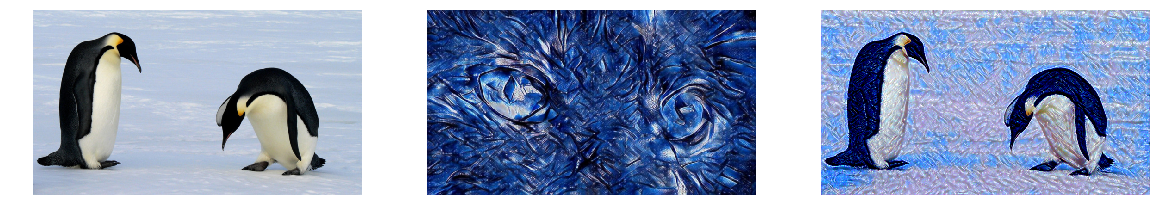

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))

ax1.imshow(im_convert(content))
ax1.axis('off')

ax2.imshow(im_convert(style))
ax2.axis('off')

ax3.imshow(im_convert(target))
ax3.axis('off')

                                                                  **Collecting all the transition to make a video**

In [0]:
import cv2

frame_height, frame_width, _ = im_convert(target).shape
vid= cv2.VideoWriter('Transition_video.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height)) 

for i in range(300):
  img= image_array[i]
  img= img * 255
  img= np.array(img, dtype= np.uint8)
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()

In [0]:
from google.colab import files
files.download('Transition_video.mp4')